<a href="https://colab.research.google.com/github/asifmanowar9/BanglaTaka/blob/main/code/Bangla_Taka(Talha).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/dataset"


**Split Dataset (70/15/15)**

In [ ]:
import os
import shutil
import random

base_dir = "/content/drive/MyDrive/dataset"
output_dir = "/content/drive/MyDrive/dataset_Split"

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = os.listdir(base_dir)

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    train_imgs = images[:700]
    val_imgs = images[700:850]
    test_imgs = images[850:1000]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("✅ Dataset split into 70% Train, 15% Val, 15% Test")


✅ Dataset split into 70% Train, 15% Val, 15% Test


In [15]:
model.save("/content/drive/MyDrive/dataset_model.h5")
print("✅ Model saved to Drive")


✅ Model saved to Drive


In [ ]:
for split in ["train", "val", "test"]:
    print(f"\n{split.upper()} SET")
    split_path = os.path.join(output_dir, split)
    for cls in os.listdir(split_path):
        count = len(os.listdir(os.path.join(split_path, cls)))
        print(cls, ":", count)



TRAIN SET
100 : 700
200 : 700
500 : 700
1000 : 700
50 : 700
2 : 700
5 : 700
10 : 700
20 : 700

VAL SET
100 : 150
200 : 150
500 : 150
1000 : 150
50 : 150
2 : 150
5 : 150
10 : 150
20 : 150

TEST SET
100 : 150
200 : 150
500 : 150
1000 : 150
50 : 150
2 : 150
5 : 150
10 : 150
20 : 150


**Load Dataset**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    os.path.join(output_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    os.path.join(output_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    os.path.join(output_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 6300 images belonging to 9 classes.
Found 1350 images belonging to 9 classes.
Found 1350 images belonging to 9 classes.


**Build the Model (MobileNetV2)**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze pretrained layers

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')  # 9 classes
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,316,873 (69.87 MB)

 Trainable params: 16,058,889 (61.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Train the Model**

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.9238 - loss: 0.3127 - val_accuracy: 0.9837 - val_loss: 0.0584
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.9957 - loss: 0.0119 - val_accuracy: 0.9919 - val_loss: 0.0271
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 835s 4s/step - accuracy: 1.0000 - loss: 3.2496e-04 - val_accuracy: 0.9941 - val_loss: 0.0252
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 1.0000 - loss: 4.2285e-05 - val_accuracy: 0.9933 - val_loss: 0.0263
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step - accuracy: 1.0000 - loss: 2.8470e-05 - val_accuracy: 0.9926 - val_loss: 0.0268
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 1.0000 - loss: 2.6190e-05 - val_accuracy: 0.9926 - val_loss: 0.0273
Epoch 7/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 1.0000 - loss: 1.8692e-05 - val_accuracy: 0.9919 - val_loss: 0.0276
Epoch 8/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 1.0000 - los

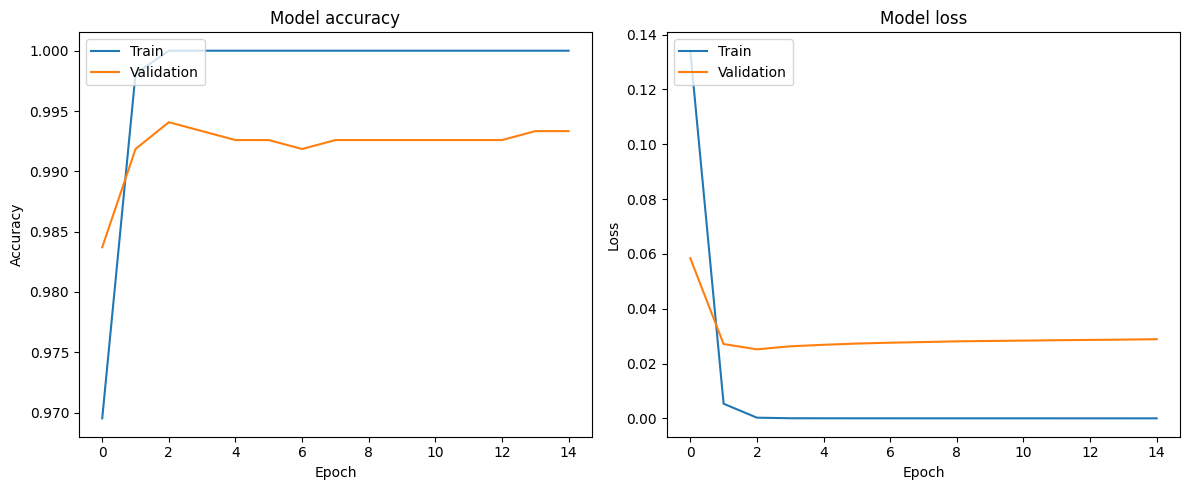

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Save the Model**

In [32]:
model.save("/content/drive/MyDrive/dataset_model_final.h5")
print("✅ Model saved to Drive")

✅ Model saved to Drive


Let's evaluate the model on the test dataset to get a better understanding of its overall performance.

**Evaluate on Test Set**

In [31]:
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9918 - loss: 0.0405
Test Loss: 0.0462
Test Accuracy: 0.9911


Please upload the image you would like to classify using the widget below.

**Test On a Single Image**

In [40]:
from google.colab import files
from io import BytesIO
from PIL import Image as PILImage
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

uploaded = files.upload()

for fn in uploaded.keys():

    img_bytes = uploaded[fn]
    img_stream = BytesIO(img_bytes)
    img = PILImage.open(img_stream)


    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0


    if 'model' not in globals():
        model_path = "/content/drive/MyDrive/dataset_model_final.h5"
        model = tf.keras.models.load_model(model_path)
        print("\n✅ Model loaded for prediction.")


    if 'train_data' in globals():
        class_labels = list(train_data.class_indices.keys())
    else:

        print("Warning: train_data not found. Attempting to infer class labels from output_dir.")
        output_dir = '/content/drive/MyDrive/dataset_Split'
        train_dir = os.path.join(output_dir, "train")
        class_labels = sorted(os.listdir(train_dir))


    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_label = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    print(f"\nUploaded image '{fn}':")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}")



Saving AM.jpg.jpeg to AM.jpg (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Uploaded image 'AM.jpg (1).jpeg':
Predicted class: 100
Confidence: 0.98
